# patch_size를 1, 3, 5, 7, 9, 11로 바꾸어 가면서 테스트 해 보자

In [1]:
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, patch_size=9, num_bands=4, temp=12, num_classes=6, 
                 d_model=64, nhead=4, num_layers=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        self.num_bands = num_bands
        self.temp = temp
        self.num_tokens = temp  # 12개 (시계열 단위)
        self.d_model = d_model  

        # ** 입력 차원 변환 (4×9×9 → d_model) **
        self.input_projection = nn.Linear(num_bands * patch_size * patch_size, d_model)

        # Positional Encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))

        # ** Layer Normalization 추가 **
        self.norm1 = nn.LayerNorm(d_model)  

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead,  
            dim_feedforward=dim_feedforward,  
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification Head (Dropout 추가)
        self.fc = nn.Sequential(
            nn.Linear(self.num_tokens * d_model, 128),  # 192 → 128
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),  # 96 → 64
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

        # ** Layer Normalization 추가 **
        self.norm2 = nn.LayerNorm(num_classes)  

        # ** 가중치 초기화 **
        self.apply(self._init_weights)  

    def forward(self, x):
        batch_size = x.shape[0]

        # (batch, 4, 12, 9, 9) → (batch, 12, 4×9×9)
        x = x.permute(0, 2, 1, 3, 4).reshape(batch_size, self.num_tokens, -1)

        # 입력 차원 변환 (4×9×9 → d_model)
        x = self.input_projection(x)

        # Add Positional Encoding
        x = x + self.pos_embedding  

        # Transformer Encoder
        x = self.norm1(x)  
        x = self.transformer(x)  

        # Flatten & Classification
        x = x.flatten(1)  
        x = self.fc(x)

        # 출력 정규화
        x = self.norm2(x)  

        return x

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)  
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

In [4]:
val_filter = lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49}

1


Epoch 1/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 148.92it/s]



Epoch [1/100], Train Loss: 0.9931, Train Accuracy: 62.89%, Val Loss: 0.7677, Val Accuracy: 71.06%



Epoch 2/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 149.48it/s]



Epoch [2/100], Train Loss: 0.7148, Train Accuracy: 74.65%, Val Loss: 0.7076, Val Accuracy: 72.14%



Epoch 3/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 152.73it/s]



Epoch [3/100], Train Loss: 0.6304, Train Accuracy: 77.56%, Val Loss: 0.6833, Val Accuracy: 74.30%



Epoch 4/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 149.37it/s]



Epoch [4/100], Train Loss: 0.5826, Train Accuracy: 79.27%, Val Loss: 0.6076, Val Accuracy: 76.89%



Epoch 5/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 151.30it/s]



Epoch [5/100], Train Loss: 0.5500, Train Accuracy: 80.43%, Val Loss: 0.5781, Val Accuracy: 77.81%



Epoch 6/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 151.87it/s]



Epoch [6/100], Train Loss: 0.5250, Train Accuracy: 81.26%, Val Loss: 0.6131, Val Accuracy: 77.03%



Epoch 7/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 151.42it/s]



Epoch [7/100], Train Loss: 0.5075, Train Accuracy: 81.72%, Val Loss: 0.5746, Val Accuracy: 78.34%



Epoch 8/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 149.70it/s]



Epoch [8/100], Train Loss: 0.4931, Train Accuracy: 82.40%, Val Loss: 0.5592, Val Accuracy: 78.65%



Epoch 9/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 150.18it/s]



Epoch [9/100], Train Loss: 0.4782, Train Accuracy: 82.88%, Val Loss: 0.5495, Val Accuracy: 79.77%



Epoch 10/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 150.54it/s]



Epoch [10/100], Train Loss: 0.4677, Train Accuracy: 83.30%, Val Loss: 0.5516, Val Accuracy: 79.32%



Epoch 11/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 150.12it/s]



Epoch [11/100], Train Loss: 0.4586, Train Accuracy: 83.61%, Val Loss: 0.5824, Val Accuracy: 78.26%



Epoch 12/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.89it/s]



Epoch [12/100], Train Loss: 0.4525, Train Accuracy: 83.62%, Val Loss: 0.5355, Val Accuracy: 80.08%



Epoch 13/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 148.51it/s]



Epoch [13/100], Train Loss: 0.4407, Train Accuracy: 84.16%, Val Loss: 0.5200, Val Accuracy: 80.52%



Epoch 14/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.22it/s]



Epoch [14/100], Train Loss: 0.4339, Train Accuracy: 84.42%, Val Loss: 0.5079, Val Accuracy: 81.13%



Epoch 15/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 148.11it/s]



Epoch [15/100], Train Loss: 0.4276, Train Accuracy: 84.59%, Val Loss: 0.5548, Val Accuracy: 79.49%



Epoch 16/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.69it/s]



Epoch [16/100], Train Loss: 0.4193, Train Accuracy: 84.92%, Val Loss: 0.5117, Val Accuracy: 81.09%



Epoch 17/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 150.24it/s]



Epoch [17/100], Train Loss: 0.4157, Train Accuracy: 85.01%, Val Loss: 0.5083, Val Accuracy: 80.91%



Epoch 18/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.14it/s]



Epoch [18/100], Train Loss: 0.4118, Train Accuracy: 85.18%, Val Loss: 0.5124, Val Accuracy: 82.07%



Epoch 19/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.12it/s]



Epoch [19/100], Train Loss: 0.4039, Train Accuracy: 85.46%, Val Loss: 0.5264, Val Accuracy: 80.60%



Epoch 20/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 148.98it/s]



Epoch [20/100], Train Loss: 0.3995, Train Accuracy: 85.65%, Val Loss: 0.5359, Val Accuracy: 80.39%



Epoch 21/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.31it/s]



Epoch [21/100], Train Loss: 0.3941, Train Accuracy: 85.77%, Val Loss: 0.5108, Val Accuracy: 81.38%



Epoch 22/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.37it/s]



Epoch [22/100], Train Loss: 0.3937, Train Accuracy: 85.69%, Val Loss: 0.5191, Val Accuracy: 81.03%



Epoch 23/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 148.38it/s]



Epoch [23/100], Train Loss: 0.3887, Train Accuracy: 86.02%, Val Loss: 0.5010, Val Accuracy: 81.66%



Epoch 24/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.29it/s]



Epoch [24/100], Train Loss: 0.3847, Train Accuracy: 86.14%, Val Loss: 0.5360, Val Accuracy: 80.57%



Epoch 25/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.47it/s]



Epoch [25/100], Train Loss: 0.3800, Train Accuracy: 86.28%, Val Loss: 0.4958, Val Accuracy: 82.32%



Epoch 26/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 144.60it/s]



Epoch [26/100], Train Loss: 0.3791, Train Accuracy: 86.35%, Val Loss: 0.5084, Val Accuracy: 82.38%



Epoch 27/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 145.78it/s]



Epoch [27/100], Train Loss: 0.3740, Train Accuracy: 86.46%, Val Loss: 0.5068, Val Accuracy: 81.99%



Epoch 28/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 146.76it/s]



Epoch [28/100], Train Loss: 0.3697, Train Accuracy: 86.62%, Val Loss: 0.5003, Val Accuracy: 82.68%



Epoch 29/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.14it/s]



Epoch [29/100], Train Loss: 0.3668, Train Accuracy: 86.73%, Val Loss: 0.5041, Val Accuracy: 81.15%



Epoch 30/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 150.95it/s]



Epoch [30/100], Train Loss: 0.3642, Train Accuracy: 86.87%, Val Loss: 0.5112, Val Accuracy: 82.37%



Epoch 31/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.09it/s]



Epoch [31/100], Train Loss: 0.3616, Train Accuracy: 86.91%, Val Loss: 0.5106, Val Accuracy: 81.74%



Epoch 32/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 148.46it/s]



Epoch [32/100], Train Loss: 0.3593, Train Accuracy: 87.05%, Val Loss: 0.5139, Val Accuracy: 82.13%



Epoch 33/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.07it/s]



Epoch [33/100], Train Loss: 0.3559, Train Accuracy: 87.12%, Val Loss: 0.5399, Val Accuracy: 80.52%



Epoch 34/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 150.76it/s]



Epoch [34/100], Train Loss: 0.3545, Train Accuracy: 87.18%, Val Loss: 0.5086, Val Accuracy: 81.42%



Epoch 35/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.47it/s]



Epoch [35/100], Train Loss: 0.3526, Train Accuracy: 87.26%, Val Loss: 0.5329, Val Accuracy: 81.64%



Epoch 36/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.74it/s]



Epoch [36/100], Train Loss: 0.3495, Train Accuracy: 87.35%, Val Loss: 0.5141, Val Accuracy: 81.86%



Epoch 37/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.12it/s]



Epoch [37/100], Train Loss: 0.3490, Train Accuracy: 87.45%, Val Loss: 0.5251, Val Accuracy: 81.35%



Epoch 38/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.94it/s]



Epoch [38/100], Train Loss: 0.3433, Train Accuracy: 87.60%, Val Loss: 0.5205, Val Accuracy: 81.66%



Epoch 39/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.89it/s]



Epoch [39/100], Train Loss: 0.3412, Train Accuracy: 87.71%, Val Loss: 0.5005, Val Accuracy: 82.61%



Epoch 40/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.27it/s]



Epoch [40/100], Train Loss: 0.3392, Train Accuracy: 87.73%, Val Loss: 0.5232, Val Accuracy: 81.74%



Epoch 41/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.78it/s]



Epoch [41/100], Train Loss: 0.3397, Train Accuracy: 87.76%, Val Loss: 0.5207, Val Accuracy: 81.81%



Epoch 42/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.09it/s]



Epoch [42/100], Train Loss: 0.3356, Train Accuracy: 87.93%, Val Loss: 0.5050, Val Accuracy: 82.68%



Epoch 43/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 150.95it/s]



Epoch [43/100], Train Loss: 0.3350, Train Accuracy: 87.89%, Val Loss: 0.5205, Val Accuracy: 82.44%



Epoch 44/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.59it/s]



Epoch [44/100], Train Loss: 0.3338, Train Accuracy: 87.87%, Val Loss: 0.4995, Val Accuracy: 82.97%



Epoch 45/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.09it/s]



Epoch [45/100], Train Loss: 0.3307, Train Accuracy: 88.09%, Val Loss: 0.5033, Val Accuracy: 82.34%



Epoch 46/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.06it/s]



Epoch [46/100], Train Loss: 0.3304, Train Accuracy: 87.97%, Val Loss: 0.5506, Val Accuracy: 81.42%



Epoch 47/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.51it/s]



Epoch [47/100], Train Loss: 0.3264, Train Accuracy: 88.22%, Val Loss: 0.5048, Val Accuracy: 82.62%



Epoch 48/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.92it/s]



Epoch [48/100], Train Loss: 0.3269, Train Accuracy: 88.23%, Val Loss: 0.5104, Val Accuracy: 82.32%



Epoch 49/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 150.85it/s]



Epoch [49/100], Train Loss: 0.3254, Train Accuracy: 88.17%, Val Loss: 0.5232, Val Accuracy: 81.93%



Epoch 50/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.61it/s]



Epoch [50/100], Train Loss: 0.3238, Train Accuracy: 88.33%, Val Loss: 0.5208, Val Accuracy: 82.04%



Epoch 51/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.69it/s]



Epoch [51/100], Train Loss: 0.3209, Train Accuracy: 88.44%, Val Loss: 0.5330, Val Accuracy: 81.72%



Epoch 52/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 149.00it/s]



Epoch [52/100], Train Loss: 0.3193, Train Accuracy: 88.47%, Val Loss: 0.5150, Val Accuracy: 82.45%



Epoch 53/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.34it/s]



Epoch [53/100], Train Loss: 0.3186, Train Accuracy: 88.43%, Val Loss: 0.5221, Val Accuracy: 82.42%



Epoch 54/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.72it/s]



Epoch [54/100], Train Loss: 0.3171, Train Accuracy: 88.45%, Val Loss: 0.4977, Val Accuracy: 82.71%



Epoch 55/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.54it/s]



Epoch [55/100], Train Loss: 0.3148, Train Accuracy: 88.60%, Val Loss: 0.5151, Val Accuracy: 82.47%



Epoch 56/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 154.24it/s]



Epoch [56/100], Train Loss: 0.3149, Train Accuracy: 88.59%, Val Loss: 0.5271, Val Accuracy: 82.32%



Epoch 57/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 154.42it/s]



Epoch [57/100], Train Loss: 0.3137, Train Accuracy: 88.61%, Val Loss: 0.5315, Val Accuracy: 82.12%



Epoch 58/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.37it/s]



Epoch [58/100], Train Loss: 0.3128, Train Accuracy: 88.65%, Val Loss: 0.5044, Val Accuracy: 82.95%



Epoch 59/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.48it/s]



Epoch [59/100], Train Loss: 0.3116, Train Accuracy: 88.67%, Val Loss: 0.5373, Val Accuracy: 81.62%



Epoch 60/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 154.14it/s]



Epoch [60/100], Train Loss: 0.3102, Train Accuracy: 88.75%, Val Loss: 0.5150, Val Accuracy: 82.53%



Epoch 61/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.62it/s]



Epoch [61/100], Train Loss: 0.3087, Train Accuracy: 88.80%, Val Loss: 0.5106, Val Accuracy: 82.47%



Epoch 62/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.13it/s]



Epoch [62/100], Train Loss: 0.3077, Train Accuracy: 88.79%, Val Loss: 0.4928, Val Accuracy: 83.14%



Epoch 63/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 154.04it/s]



Epoch [63/100], Train Loss: 0.3040, Train Accuracy: 89.06%, Val Loss: 0.5154, Val Accuracy: 82.74%



Epoch 64/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 154.80it/s]



Epoch [64/100], Train Loss: 0.3041, Train Accuracy: 89.00%, Val Loss: 0.5322, Val Accuracy: 82.25%



Epoch 65/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.83it/s]



Epoch [65/100], Train Loss: 0.3050, Train Accuracy: 88.94%, Val Loss: 0.5157, Val Accuracy: 82.19%



Epoch 66/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.31it/s]



Epoch [66/100], Train Loss: 0.3030, Train Accuracy: 89.03%, Val Loss: 0.5414, Val Accuracy: 81.84%



Epoch 67/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.39it/s]



Epoch [67/100], Train Loss: 0.3015, Train Accuracy: 89.05%, Val Loss: 0.5446, Val Accuracy: 81.76%



Epoch 68/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.96it/s]



Epoch [68/100], Train Loss: 0.2987, Train Accuracy: 89.19%, Val Loss: 0.5478, Val Accuracy: 81.57%



Epoch 69/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.09it/s]



Epoch [69/100], Train Loss: 0.2984, Train Accuracy: 89.27%, Val Loss: 0.5134, Val Accuracy: 82.92%



Epoch 70/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 155.36it/s]



Epoch [70/100], Train Loss: 0.2995, Train Accuracy: 89.17%, Val Loss: 0.5602, Val Accuracy: 81.47%



Epoch 71/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 155.26it/s]



Epoch [71/100], Train Loss: 0.2963, Train Accuracy: 89.25%, Val Loss: 0.5284, Val Accuracy: 81.91%



Epoch 72/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.65it/s]



Epoch [72/100], Train Loss: 0.2964, Train Accuracy: 89.29%, Val Loss: 0.5424, Val Accuracy: 81.72%



Epoch 73/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.53it/s]



Epoch [73/100], Train Loss: 0.2930, Train Accuracy: 89.41%, Val Loss: 0.5209, Val Accuracy: 82.63%



Epoch 74/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.18it/s]



Epoch [74/100], Train Loss: 0.2943, Train Accuracy: 89.38%, Val Loss: 0.5250, Val Accuracy: 82.53%



Epoch 75/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.97it/s]



Epoch [75/100], Train Loss: 0.2929, Train Accuracy: 89.41%, Val Loss: 0.5182, Val Accuracy: 82.67%



Epoch 76/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.84it/s]



Epoch [76/100], Train Loss: 0.2934, Train Accuracy: 89.36%, Val Loss: 0.5351, Val Accuracy: 82.36%



Epoch 77/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.88it/s]



Epoch [77/100], Train Loss: 0.2920, Train Accuracy: 89.37%, Val Loss: 0.5059, Val Accuracy: 82.99%



Epoch 78/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 154.26it/s]



Epoch [78/100], Train Loss: 0.2905, Train Accuracy: 89.44%, Val Loss: 0.5293, Val Accuracy: 82.53%



Epoch 79/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 155.11it/s]



Epoch [79/100], Train Loss: 0.2908, Train Accuracy: 89.51%, Val Loss: 0.5360, Val Accuracy: 82.16%



Epoch 80/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.02it/s]



Epoch [80/100], Train Loss: 0.2894, Train Accuracy: 89.41%, Val Loss: 0.5266, Val Accuracy: 82.70%



Epoch 81/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.82it/s]



Epoch [81/100], Train Loss: 0.2871, Train Accuracy: 89.64%, Val Loss: 0.5406, Val Accuracy: 82.09%



Epoch 82/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.77it/s]



Epoch [82/100], Train Loss: 0.2856, Train Accuracy: 89.58%, Val Loss: 0.5183, Val Accuracy: 83.01%



Epoch 83/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.22it/s]



Epoch [83/100], Train Loss: 0.2828, Train Accuracy: 89.78%, Val Loss: 0.5237, Val Accuracy: 82.42%



Epoch 84/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.72it/s]



Epoch [84/100], Train Loss: 0.2858, Train Accuracy: 89.62%, Val Loss: 0.5414, Val Accuracy: 82.22%



Epoch 85/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 150.04it/s]



Epoch [85/100], Train Loss: 0.2829, Train Accuracy: 89.73%, Val Loss: 0.5594, Val Accuracy: 81.92%



Epoch 86/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.93it/s]



Epoch [86/100], Train Loss: 0.2844, Train Accuracy: 89.68%, Val Loss: 0.5627, Val Accuracy: 82.02%



Epoch 87/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 154.47it/s]



Epoch [87/100], Train Loss: 0.2818, Train Accuracy: 89.80%, Val Loss: 0.5319, Val Accuracy: 82.45%



Epoch 88/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 154.41it/s]



Epoch [88/100], Train Loss: 0.2831, Train Accuracy: 89.73%, Val Loss: 0.5350, Val Accuracy: 82.34%



Epoch 89/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.81it/s]



Epoch [89/100], Train Loss: 0.2797, Train Accuracy: 89.83%, Val Loss: 0.5582, Val Accuracy: 81.57%



Epoch 90/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.81it/s]



Epoch [90/100], Train Loss: 0.2798, Train Accuracy: 89.91%, Val Loss: 0.5201, Val Accuracy: 83.10%



Epoch 91/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.70it/s]



Epoch [91/100], Train Loss: 0.2785, Train Accuracy: 89.96%, Val Loss: 0.5376, Val Accuracy: 82.56%



Epoch 92/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.22it/s]



Epoch [92/100], Train Loss: 0.2794, Train Accuracy: 89.88%, Val Loss: 0.5195, Val Accuracy: 82.79%



Epoch 93/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 154.58it/s]



Epoch [93/100], Train Loss: 0.2777, Train Accuracy: 89.92%, Val Loss: 0.5080, Val Accuracy: 83.06%



Epoch 94/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.20it/s]



Epoch [94/100], Train Loss: 0.2784, Train Accuracy: 89.93%, Val Loss: 0.5819, Val Accuracy: 81.33%



Epoch 95/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 151.87it/s]



Epoch [95/100], Train Loss: 0.2773, Train Accuracy: 89.92%, Val Loss: 0.5230, Val Accuracy: 82.60%



Epoch 96/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 152.65it/s]



Epoch [96/100], Train Loss: 0.2755, Train Accuracy: 89.93%, Val Loss: 0.5751, Val Accuracy: 81.66%



Epoch 97/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 154.00it/s]



Epoch [97/100], Train Loss: 0.2751, Train Accuracy: 90.05%, Val Loss: 0.5456, Val Accuracy: 82.50%



Epoch 98/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 153.98it/s]



Epoch [98/100], Train Loss: 0.2727, Train Accuracy: 90.09%, Val Loss: 0.5553, Val Accuracy: 81.77%



Epoch 99/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 155.05it/s]



Epoch [99/100], Train Loss: 0.2713, Train Accuracy: 90.23%, Val Loss: 0.5442, Val Accuracy: 82.00%



Epoch 100/100 - Validation: 100%|███████████████████████████| 940/940 [00:06<00:00, 153.49it/s]



Epoch [100/100], Train Loss: 0.2717, Train Accuracy: 90.19%, Val Loss: 0.5118, Val Accuracy: 83.14%

train data


Evaluation Progress: 100%|████████████████████████████████| 3796/3796 [00:24<00:00, 153.29it/s]


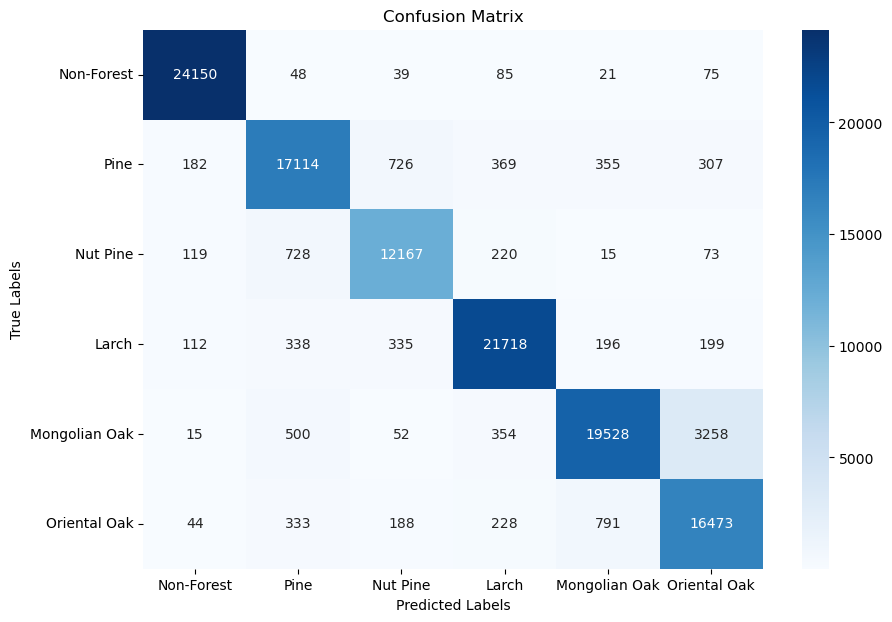

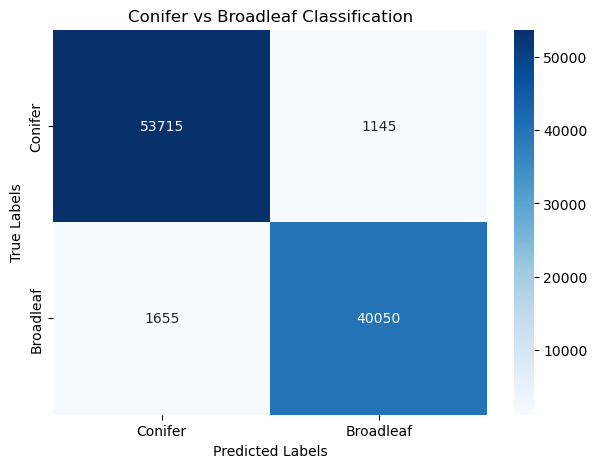

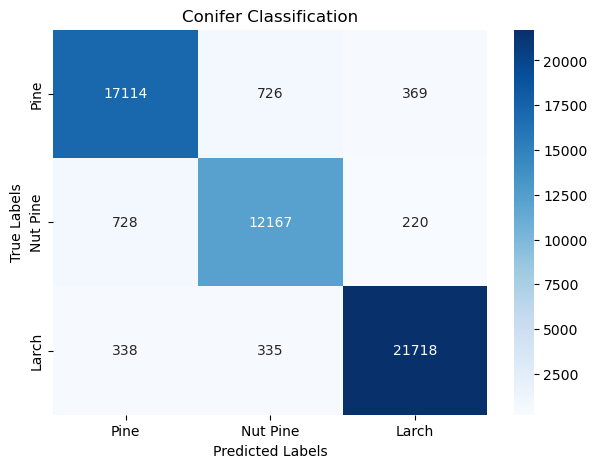

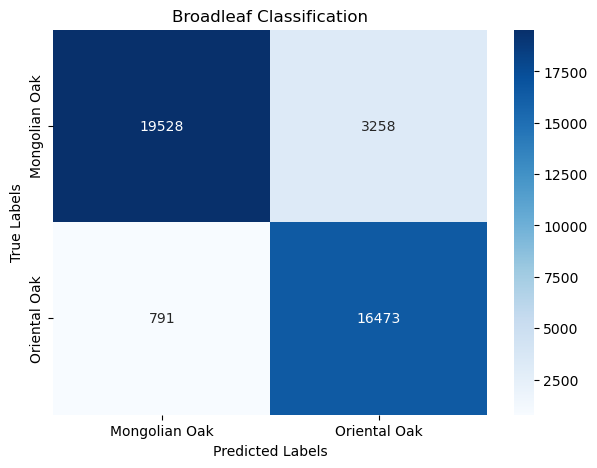

validation data


Evaluation Progress: 100%|██████████████████████████████████| 940/940 [00:06<00:00, 152.66it/s]


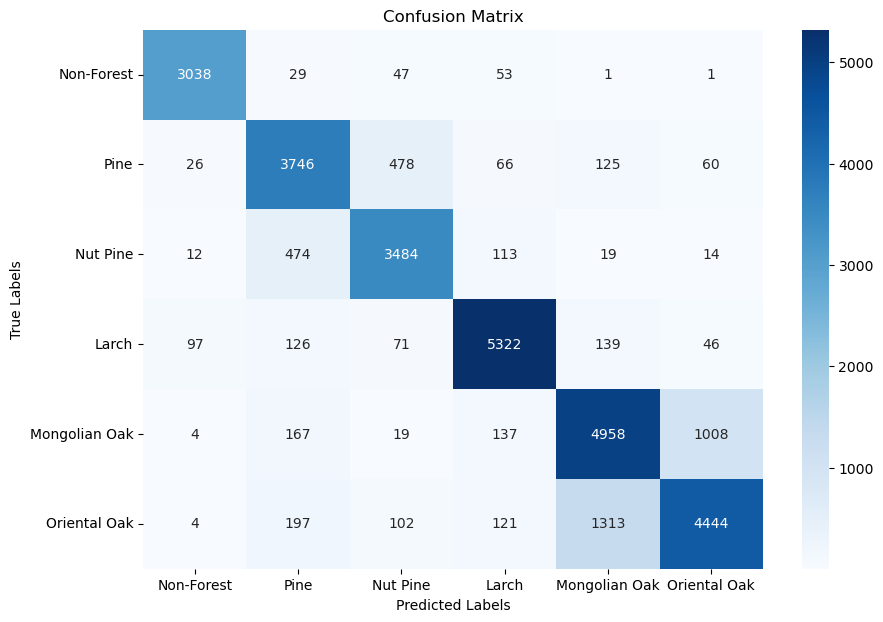

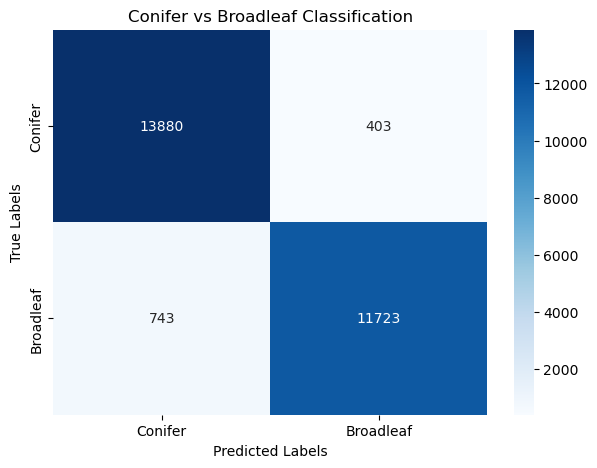

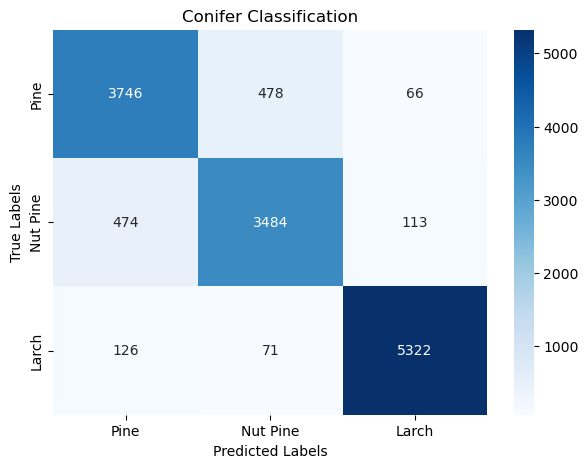

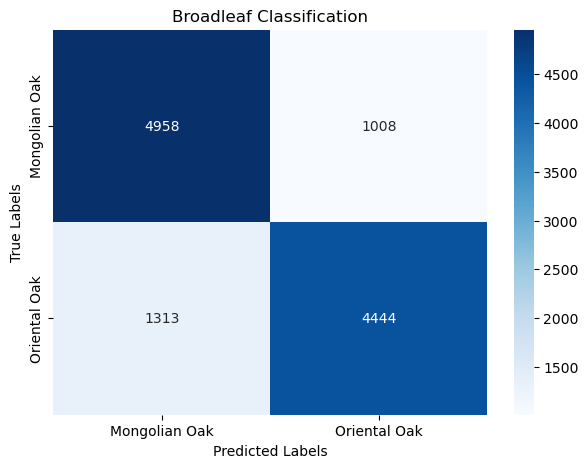

3


Epoch 1/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 141.41it/s]



Epoch [1/100], Train Loss: 0.9817, Train Accuracy: 63.15%, Val Loss: 0.7500, Val Accuracy: 72.65%



Epoch 2/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 140.50it/s]



Epoch [2/100], Train Loss: 0.6903, Train Accuracy: 75.77%, Val Loss: 0.6564, Val Accuracy: 74.28%



Epoch 3/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 138.83it/s]



Epoch [3/100], Train Loss: 0.5966, Train Accuracy: 78.90%, Val Loss: 0.5808, Val Accuracy: 78.82%



Epoch 4/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 138.25it/s]



Epoch [4/100], Train Loss: 0.5416, Train Accuracy: 80.95%, Val Loss: 0.6018, Val Accuracy: 77.37%



Epoch 5/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 141.01it/s]



Epoch [5/100], Train Loss: 0.5042, Train Accuracy: 82.14%, Val Loss: 0.5374, Val Accuracy: 80.30%



Epoch 6/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 139.64it/s]



Epoch [6/100], Train Loss: 0.4748, Train Accuracy: 83.23%, Val Loss: 0.5155, Val Accuracy: 80.50%



Epoch 7/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 141.22it/s]



Epoch [7/100], Train Loss: 0.4509, Train Accuracy: 84.19%, Val Loss: 0.4925, Val Accuracy: 81.69%



Epoch 8/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 139.91it/s]



Epoch [8/100], Train Loss: 0.4360, Train Accuracy: 84.64%, Val Loss: 0.5064, Val Accuracy: 80.75%



Epoch 9/100 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 140.21it/s]



Epoch [9/100], Train Loss: 0.4211, Train Accuracy: 85.11%, Val Loss: 0.5050, Val Accuracy: 81.52%



Epoch 10/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.68it/s]



Epoch [10/100], Train Loss: 0.4073, Train Accuracy: 85.62%, Val Loss: 0.4910, Val Accuracy: 82.24%



Epoch 11/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.86it/s]



Epoch [11/100], Train Loss: 0.3978, Train Accuracy: 85.86%, Val Loss: 0.4882, Val Accuracy: 82.68%



Epoch 12/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.90it/s]



Epoch [12/100], Train Loss: 0.3853, Train Accuracy: 86.42%, Val Loss: 0.4593, Val Accuracy: 83.39%



Epoch 13/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.64it/s]



Epoch [13/100], Train Loss: 0.3784, Train Accuracy: 86.58%, Val Loss: 0.4702, Val Accuracy: 82.93%



Epoch 14/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.55it/s]



Epoch [14/100], Train Loss: 0.3703, Train Accuracy: 86.88%, Val Loss: 0.4831, Val Accuracy: 82.70%



Epoch 15/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.15it/s]



Epoch [15/100], Train Loss: 0.3625, Train Accuracy: 87.14%, Val Loss: 0.4640, Val Accuracy: 83.87%



Epoch 16/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.61it/s]



Epoch [16/100], Train Loss: 0.3567, Train Accuracy: 87.31%, Val Loss: 0.4820, Val Accuracy: 82.91%



Epoch 17/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 141.01it/s]



Epoch [17/100], Train Loss: 0.3493, Train Accuracy: 87.48%, Val Loss: 0.4575, Val Accuracy: 84.08%



Epoch 18/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.83it/s]



Epoch [18/100], Train Loss: 0.3443, Train Accuracy: 87.84%, Val Loss: 0.4717, Val Accuracy: 83.20%



Epoch 19/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.50it/s]



Epoch [19/100], Train Loss: 0.3394, Train Accuracy: 87.98%, Val Loss: 0.4681, Val Accuracy: 83.81%



Epoch 20/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.37it/s]



Epoch [20/100], Train Loss: 0.3332, Train Accuracy: 88.23%, Val Loss: 0.4828, Val Accuracy: 83.67%



Epoch 21/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 142.46it/s]



Epoch [21/100], Train Loss: 0.3288, Train Accuracy: 88.26%, Val Loss: 0.4775, Val Accuracy: 83.24%



Epoch 22/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.16it/s]



Epoch [22/100], Train Loss: 0.3228, Train Accuracy: 88.61%, Val Loss: 0.4703, Val Accuracy: 83.45%



Epoch 23/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.67it/s]



Epoch [23/100], Train Loss: 0.3217, Train Accuracy: 88.60%, Val Loss: 0.5026, Val Accuracy: 83.19%



Epoch 24/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.56it/s]



Epoch [24/100], Train Loss: 0.3172, Train Accuracy: 88.79%, Val Loss: 0.4677, Val Accuracy: 83.40%



Epoch 25/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 141.55it/s]



Epoch [25/100], Train Loss: 0.3101, Train Accuracy: 88.94%, Val Loss: 0.5054, Val Accuracy: 82.12%



Epoch 26/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.79it/s]



Epoch [26/100], Train Loss: 0.3066, Train Accuracy: 88.98%, Val Loss: 0.4697, Val Accuracy: 84.00%



Epoch 27/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.21it/s]



Epoch [27/100], Train Loss: 0.3043, Train Accuracy: 89.18%, Val Loss: 0.4807, Val Accuracy: 83.40%



Epoch 28/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.76it/s]



Epoch [28/100], Train Loss: 0.3018, Train Accuracy: 89.27%, Val Loss: 0.4582, Val Accuracy: 83.85%



Epoch 29/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.96it/s]



Epoch [29/100], Train Loss: 0.2996, Train Accuracy: 89.30%, Val Loss: 0.4741, Val Accuracy: 84.20%



Epoch 30/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.33it/s]



Epoch [30/100], Train Loss: 0.2947, Train Accuracy: 89.53%, Val Loss: 0.4824, Val Accuracy: 83.81%



Epoch 31/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.81it/s]



Epoch [31/100], Train Loss: 0.2908, Train Accuracy: 89.72%, Val Loss: 0.4784, Val Accuracy: 84.33%



Epoch 32/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.29it/s]



Epoch [32/100], Train Loss: 0.2877, Train Accuracy: 89.82%, Val Loss: 0.4745, Val Accuracy: 83.65%



Epoch 33/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.38it/s]



Epoch [33/100], Train Loss: 0.2863, Train Accuracy: 89.86%, Val Loss: 0.4998, Val Accuracy: 82.67%



Epoch 34/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 141.66it/s]



Epoch [34/100], Train Loss: 0.2863, Train Accuracy: 89.85%, Val Loss: 0.4606, Val Accuracy: 84.38%



Epoch 35/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.05it/s]



Epoch [35/100], Train Loss: 0.2808, Train Accuracy: 90.00%, Val Loss: 0.5111, Val Accuracy: 83.65%



Epoch 36/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.42it/s]



Epoch [36/100], Train Loss: 0.2785, Train Accuracy: 90.03%, Val Loss: 0.4807, Val Accuracy: 83.64%



Epoch 37/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 141.25it/s]



Epoch [37/100], Train Loss: 0.2759, Train Accuracy: 90.23%, Val Loss: 0.4683, Val Accuracy: 84.59%



Epoch 38/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.73it/s]



Epoch [38/100], Train Loss: 0.2727, Train Accuracy: 90.29%, Val Loss: 0.4683, Val Accuracy: 84.55%



Epoch 39/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.61it/s]



Epoch [39/100], Train Loss: 0.2691, Train Accuracy: 90.46%, Val Loss: 0.4750, Val Accuracy: 84.00%



Epoch 40/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.86it/s]



Epoch [40/100], Train Loss: 0.2671, Train Accuracy: 90.49%, Val Loss: 0.4939, Val Accuracy: 83.65%



Epoch 41/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.64it/s]



Epoch [41/100], Train Loss: 0.2656, Train Accuracy: 90.52%, Val Loss: 0.5094, Val Accuracy: 83.19%



Epoch 42/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 141.18it/s]



Epoch [42/100], Train Loss: 0.2646, Train Accuracy: 90.60%, Val Loss: 0.4777, Val Accuracy: 84.40%



Epoch 43/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.73it/s]



Epoch [43/100], Train Loss: 0.2607, Train Accuracy: 90.68%, Val Loss: 0.5171, Val Accuracy: 83.48%



Epoch 44/100 - Validation: 100%|████████████████████████████| 940/940 [00:07<00:00, 134.18it/s]



Epoch [44/100], Train Loss: 0.2595, Train Accuracy: 90.73%, Val Loss: 0.5048, Val Accuracy: 83.42%



Epoch 45/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 141.28it/s]



Epoch [45/100], Train Loss: 0.2578, Train Accuracy: 90.82%, Val Loss: 0.5111, Val Accuracy: 83.50%



Epoch 46/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.50it/s]



Epoch [46/100], Train Loss: 0.2557, Train Accuracy: 91.00%, Val Loss: 0.5180, Val Accuracy: 83.18%



Epoch 47/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 141.26it/s]



Epoch [47/100], Train Loss: 0.2514, Train Accuracy: 91.00%, Val Loss: 0.4880, Val Accuracy: 83.59%



Epoch 48/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.61it/s]



Epoch [48/100], Train Loss: 0.2514, Train Accuracy: 91.04%, Val Loss: 0.5192, Val Accuracy: 83.58%



Epoch 49/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.81it/s]



Epoch [49/100], Train Loss: 0.2498, Train Accuracy: 91.09%, Val Loss: 0.4894, Val Accuracy: 84.15%



Epoch 50/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.36it/s]



Epoch [50/100], Train Loss: 0.2455, Train Accuracy: 91.29%, Val Loss: 0.5005, Val Accuracy: 84.42%



Epoch 51/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 136.33it/s]



Epoch [51/100], Train Loss: 0.2465, Train Accuracy: 91.16%, Val Loss: 0.5160, Val Accuracy: 83.34%



Epoch 52/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.26it/s]



Epoch [52/100], Train Loss: 0.2433, Train Accuracy: 91.40%, Val Loss: 0.5229, Val Accuracy: 82.87%



Epoch 53/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 136.92it/s]



Epoch [53/100], Train Loss: 0.2421, Train Accuracy: 91.45%, Val Loss: 0.5282, Val Accuracy: 83.06%



Epoch 54/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.95it/s]



Epoch [54/100], Train Loss: 0.2432, Train Accuracy: 91.32%, Val Loss: 0.4840, Val Accuracy: 84.34%



Epoch 55/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.92it/s]



Epoch [55/100], Train Loss: 0.2379, Train Accuracy: 91.54%, Val Loss: 0.5261, Val Accuracy: 83.52%



Epoch 56/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.82it/s]



Epoch [56/100], Train Loss: 0.2385, Train Accuracy: 91.61%, Val Loss: 0.4888, Val Accuracy: 84.86%



Epoch 57/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.58it/s]



Epoch [57/100], Train Loss: 0.2367, Train Accuracy: 91.56%, Val Loss: 0.5253, Val Accuracy: 83.58%



Epoch 58/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 135.41it/s]



Epoch [58/100], Train Loss: 0.2366, Train Accuracy: 91.56%, Val Loss: 0.5013, Val Accuracy: 84.23%



Epoch 59/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.11it/s]



Epoch [59/100], Train Loss: 0.2352, Train Accuracy: 91.75%, Val Loss: 0.5040, Val Accuracy: 83.82%



Epoch 60/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.38it/s]



Epoch [60/100], Train Loss: 0.2346, Train Accuracy: 91.68%, Val Loss: 0.4929, Val Accuracy: 84.24%



Epoch 61/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.68it/s]



Epoch [61/100], Train Loss: 0.2315, Train Accuracy: 91.78%, Val Loss: 0.5177, Val Accuracy: 83.90%



Epoch 62/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.89it/s]



Epoch [62/100], Train Loss: 0.2284, Train Accuracy: 91.93%, Val Loss: 0.4867, Val Accuracy: 84.84%



Epoch 63/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.19it/s]



Epoch [63/100], Train Loss: 0.2279, Train Accuracy: 91.88%, Val Loss: 0.4974, Val Accuracy: 84.38%



Epoch 64/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.21it/s]



Epoch [64/100], Train Loss: 0.2281, Train Accuracy: 91.92%, Val Loss: 0.5302, Val Accuracy: 83.43%



Epoch 65/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.28it/s]



Epoch [65/100], Train Loss: 0.2260, Train Accuracy: 92.00%, Val Loss: 0.5252, Val Accuracy: 83.81%



Epoch 66/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.56it/s]



Epoch [66/100], Train Loss: 0.2260, Train Accuracy: 92.08%, Val Loss: 0.5058, Val Accuracy: 84.55%



Epoch 67/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.49it/s]



Epoch [67/100], Train Loss: 0.2234, Train Accuracy: 92.09%, Val Loss: 0.5451, Val Accuracy: 83.24%



Epoch 68/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.63it/s]



Epoch [68/100], Train Loss: 0.2239, Train Accuracy: 92.06%, Val Loss: 0.4895, Val Accuracy: 84.14%



Epoch 69/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.97it/s]



Epoch [69/100], Train Loss: 0.2210, Train Accuracy: 92.15%, Val Loss: 0.4988, Val Accuracy: 84.63%



Epoch 70/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 141.01it/s]



Epoch [70/100], Train Loss: 0.2191, Train Accuracy: 92.25%, Val Loss: 0.5261, Val Accuracy: 83.93%



Epoch 71/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.47it/s]



Epoch [71/100], Train Loss: 0.2188, Train Accuracy: 92.23%, Val Loss: 0.5548, Val Accuracy: 82.94%



Epoch 72/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.25it/s]



Epoch [72/100], Train Loss: 0.2198, Train Accuracy: 92.25%, Val Loss: 0.5081, Val Accuracy: 84.05%



Epoch 73/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.98it/s]



Epoch [73/100], Train Loss: 0.2137, Train Accuracy: 92.40%, Val Loss: 0.5408, Val Accuracy: 83.97%



Epoch 74/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.97it/s]



Epoch [74/100], Train Loss: 0.2149, Train Accuracy: 92.40%, Val Loss: 0.5333, Val Accuracy: 83.54%



Epoch 75/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.90it/s]



Epoch [75/100], Train Loss: 0.2141, Train Accuracy: 92.40%, Val Loss: 0.4854, Val Accuracy: 84.82%



Epoch 76/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.31it/s]



Epoch [76/100], Train Loss: 0.2130, Train Accuracy: 92.41%, Val Loss: 0.5211, Val Accuracy: 84.09%



Epoch 77/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.55it/s]



Epoch [77/100], Train Loss: 0.2109, Train Accuracy: 92.53%, Val Loss: 0.5544, Val Accuracy: 83.42%



Epoch 78/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 135.99it/s]



Epoch [78/100], Train Loss: 0.2112, Train Accuracy: 92.53%, Val Loss: 0.5076, Val Accuracy: 84.63%



Epoch 79/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.18it/s]



Epoch [79/100], Train Loss: 0.2110, Train Accuracy: 92.45%, Val Loss: 0.4994, Val Accuracy: 84.79%



Epoch 80/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.24it/s]



Epoch [80/100], Train Loss: 0.2100, Train Accuracy: 92.57%, Val Loss: 0.5536, Val Accuracy: 83.64%



Epoch 81/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.11it/s]



Epoch [81/100], Train Loss: 0.2083, Train Accuracy: 92.62%, Val Loss: 0.5448, Val Accuracy: 83.65%



Epoch 82/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.68it/s]



Epoch [82/100], Train Loss: 0.2064, Train Accuracy: 92.73%, Val Loss: 0.5309, Val Accuracy: 84.25%



Epoch 83/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.40it/s]



Epoch [83/100], Train Loss: 0.2062, Train Accuracy: 92.75%, Val Loss: 0.5484, Val Accuracy: 83.53%



Epoch 84/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.03it/s]



Epoch [84/100], Train Loss: 0.2063, Train Accuracy: 92.73%, Val Loss: 0.5262, Val Accuracy: 83.78%



Epoch 85/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 136.07it/s]



Epoch [85/100], Train Loss: 0.2033, Train Accuracy: 92.84%, Val Loss: 0.5297, Val Accuracy: 84.10%



Epoch 86/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.50it/s]



Epoch [86/100], Train Loss: 0.2037, Train Accuracy: 92.79%, Val Loss: 0.5069, Val Accuracy: 84.50%



Epoch 87/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.86it/s]



Epoch [87/100], Train Loss: 0.2027, Train Accuracy: 92.77%, Val Loss: 0.5501, Val Accuracy: 82.83%



Epoch 88/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 137.93it/s]



Epoch [88/100], Train Loss: 0.2014, Train Accuracy: 92.87%, Val Loss: 0.5292, Val Accuracy: 83.90%



Epoch 89/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 140.24it/s]



Epoch [89/100], Train Loss: 0.2003, Train Accuracy: 92.93%, Val Loss: 0.5210, Val Accuracy: 84.31%



Epoch 90/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.87it/s]



Epoch [90/100], Train Loss: 0.1990, Train Accuracy: 92.92%, Val Loss: 0.5229, Val Accuracy: 84.11%



Epoch 91/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.11it/s]



Epoch [91/100], Train Loss: 0.1984, Train Accuracy: 92.93%, Val Loss: 0.5103, Val Accuracy: 84.44%



Epoch 92/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 136.47it/s]



Epoch [92/100], Train Loss: 0.1994, Train Accuracy: 93.00%, Val Loss: 0.5283, Val Accuracy: 84.21%



Epoch 93/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.57it/s]



Epoch [93/100], Train Loss: 0.1952, Train Accuracy: 93.15%, Val Loss: 0.5500, Val Accuracy: 83.53%



Epoch 94/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 138.19it/s]



Epoch [94/100], Train Loss: 0.1962, Train Accuracy: 93.06%, Val Loss: 0.5146, Val Accuracy: 84.71%



Epoch 95/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 136.75it/s]



Epoch [95/100], Train Loss: 0.1950, Train Accuracy: 93.11%, Val Loss: 0.5380, Val Accuracy: 84.36%



Epoch 96/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 136.92it/s]



Epoch [96/100], Train Loss: 0.1934, Train Accuracy: 93.20%, Val Loss: 0.5796, Val Accuracy: 83.00%



Epoch 97/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.33it/s]



Epoch [97/100], Train Loss: 0.1946, Train Accuracy: 93.08%, Val Loss: 0.5545, Val Accuracy: 83.87%



Epoch 98/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.74it/s]



Epoch [98/100], Train Loss: 0.1947, Train Accuracy: 93.07%, Val Loss: 0.5147, Val Accuracy: 84.52%



Epoch 99/100 - Validation: 100%|████████████████████████████| 940/940 [00:06<00:00, 139.56it/s]



Epoch [99/100], Train Loss: 0.1935, Train Accuracy: 93.13%, Val Loss: 0.5589, Val Accuracy: 83.27%



Epoch 100/100 - Validation: 100%|███████████████████████████| 940/940 [00:06<00:00, 139.95it/s]



Epoch [100/100], Train Loss: 0.1904, Train Accuracy: 93.23%, Val Loss: 0.5544, Val Accuracy: 83.77%

train data


Evaluation Progress: 100%|████████████████████████████████| 3796/3796 [00:27<00:00, 139.87it/s]


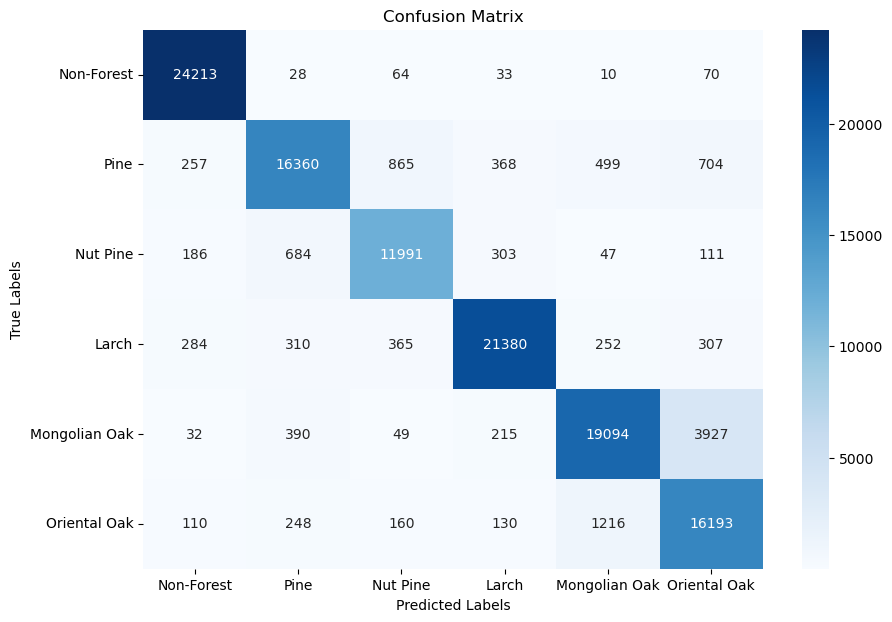

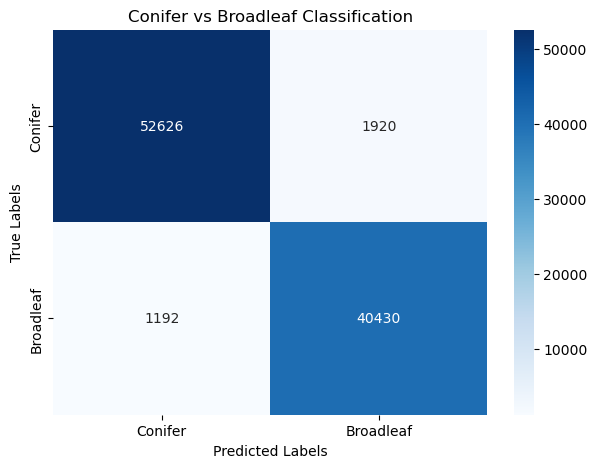

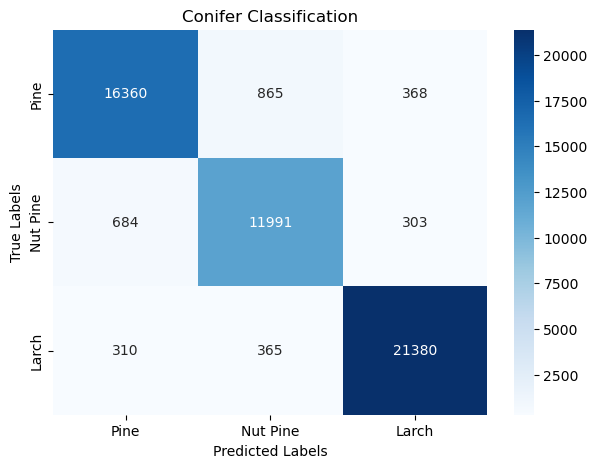

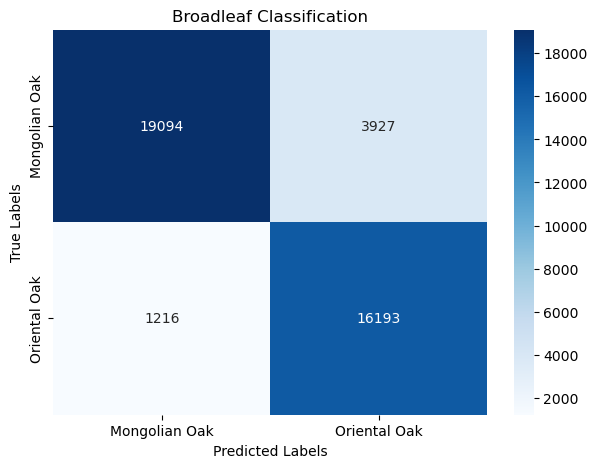

validation data


Evaluation Progress: 100%|██████████████████████████████████| 940/940 [00:06<00:00, 140.75it/s]


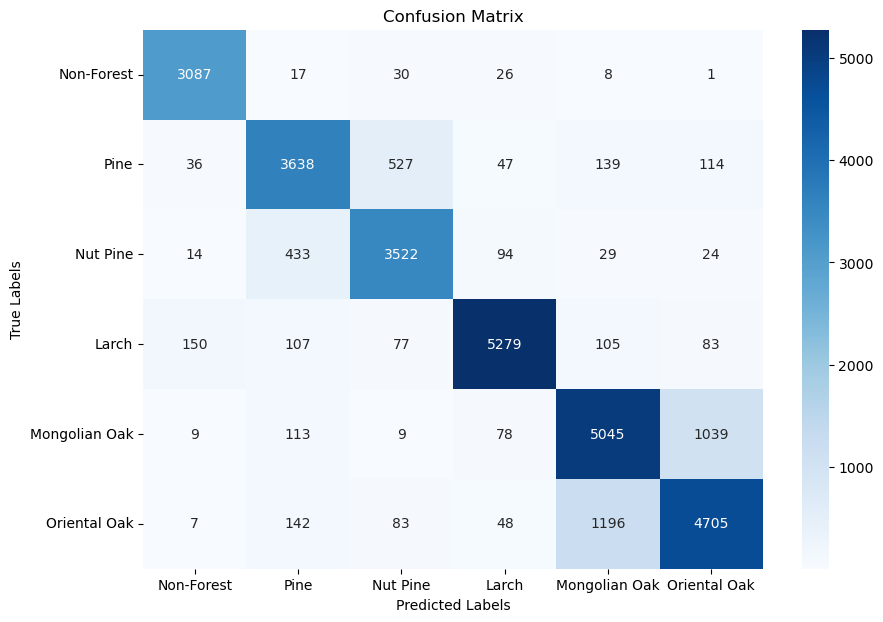

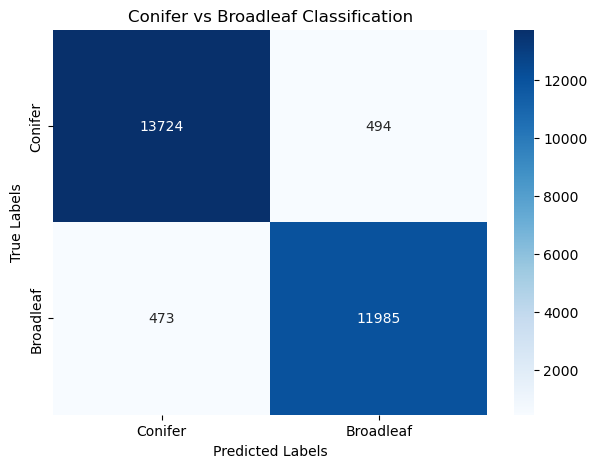

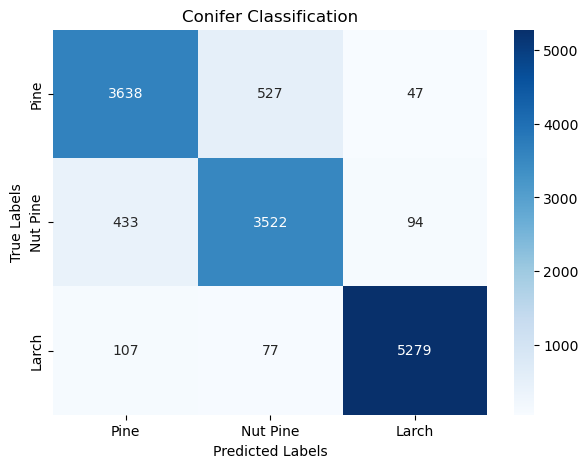

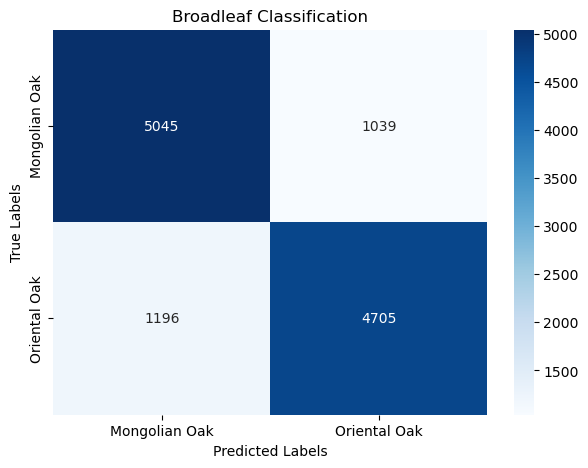

5


Epoch 1/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 133.77it/s]



Epoch [1/100], Train Loss: 0.9914, Train Accuracy: 62.89%, Val Loss: 0.7956, Val Accuracy: 69.23%



Epoch 2/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 130.34it/s]



Epoch [2/100], Train Loss: 0.6617, Train Accuracy: 76.99%, Val Loss: 0.6058, Val Accuracy: 77.18%



Epoch 3/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 131.10it/s]



Epoch [3/100], Train Loss: 0.5706, Train Accuracy: 79.88%, Val Loss: 0.5709, Val Accuracy: 78.57%



Epoch 4/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 130.42it/s]



Epoch [4/100], Train Loss: 0.5166, Train Accuracy: 81.77%, Val Loss: 0.5326, Val Accuracy: 80.53%



Epoch 5/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 129.86it/s]



Epoch [5/100], Train Loss: 0.4795, Train Accuracy: 83.04%, Val Loss: 0.5213, Val Accuracy: 80.79%



Epoch 6/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 131.11it/s]



Epoch [6/100], Train Loss: 0.4505, Train Accuracy: 84.08%, Val Loss: 0.5284, Val Accuracy: 80.56%



Epoch 7/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 133.25it/s]



Epoch [7/100], Train Loss: 0.4264, Train Accuracy: 85.09%, Val Loss: 0.5180, Val Accuracy: 81.06%



Epoch 8/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 135.00it/s]



Epoch [8/100], Train Loss: 0.4097, Train Accuracy: 85.65%, Val Loss: 0.5021, Val Accuracy: 82.25%



Epoch 9/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 133.86it/s]



Epoch [9/100], Train Loss: 0.3956, Train Accuracy: 86.04%, Val Loss: 0.5363, Val Accuracy: 80.29%



Epoch 10/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.34it/s]



Epoch [10/100], Train Loss: 0.3810, Train Accuracy: 86.52%, Val Loss: 0.4704, Val Accuracy: 83.15%



Epoch 11/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.00it/s]



Epoch [11/100], Train Loss: 0.3696, Train Accuracy: 86.97%, Val Loss: 0.4666, Val Accuracy: 83.58%



Epoch 12/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.32it/s]



Epoch [12/100], Train Loss: 0.3607, Train Accuracy: 87.35%, Val Loss: 0.5523, Val Accuracy: 81.05%



Epoch 13/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.63it/s]



Epoch [13/100], Train Loss: 0.3511, Train Accuracy: 87.68%, Val Loss: 0.4817, Val Accuracy: 83.28%



Epoch 14/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.50it/s]



Epoch [14/100], Train Loss: 0.3413, Train Accuracy: 88.04%, Val Loss: 0.4619, Val Accuracy: 83.64%



Epoch 15/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.41it/s]



Epoch [15/100], Train Loss: 0.3345, Train Accuracy: 88.28%, Val Loss: 0.4877, Val Accuracy: 83.76%



Epoch 16/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.91it/s]



Epoch [16/100], Train Loss: 0.3265, Train Accuracy: 88.58%, Val Loss: 0.4682, Val Accuracy: 83.72%



Epoch 17/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.12it/s]



Epoch [17/100], Train Loss: 0.3202, Train Accuracy: 88.82%, Val Loss: 0.4564, Val Accuracy: 84.53%



Epoch 18/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.10it/s]



Epoch [18/100], Train Loss: 0.3108, Train Accuracy: 89.14%, Val Loss: 0.4963, Val Accuracy: 82.78%



Epoch 19/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.29it/s]



Epoch [19/100], Train Loss: 0.3063, Train Accuracy: 89.26%, Val Loss: 0.4933, Val Accuracy: 83.18%



Epoch 20/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.64it/s]



Epoch [20/100], Train Loss: 0.3011, Train Accuracy: 89.48%, Val Loss: 0.4624, Val Accuracy: 84.60%



Epoch 21/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.99it/s]



Epoch [21/100], Train Loss: 0.2977, Train Accuracy: 89.58%, Val Loss: 0.4806, Val Accuracy: 84.32%



Epoch 22/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.19it/s]



Epoch [22/100], Train Loss: 0.2919, Train Accuracy: 89.85%, Val Loss: 0.4797, Val Accuracy: 84.26%



Epoch 23/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.72it/s]



Epoch [23/100], Train Loss: 0.2879, Train Accuracy: 89.98%, Val Loss: 0.4718, Val Accuracy: 84.83%



Epoch 24/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.12it/s]



Epoch [24/100], Train Loss: 0.2828, Train Accuracy: 90.15%, Val Loss: 0.4763, Val Accuracy: 84.62%



Epoch 25/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 130.71it/s]



Epoch [25/100], Train Loss: 0.2795, Train Accuracy: 90.28%, Val Loss: 0.5059, Val Accuracy: 83.97%



Epoch 26/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.42it/s]



Epoch [26/100], Train Loss: 0.2766, Train Accuracy: 90.33%, Val Loss: 0.4879, Val Accuracy: 83.57%



Epoch 27/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 130.75it/s]



Epoch [27/100], Train Loss: 0.2707, Train Accuracy: 90.62%, Val Loss: 0.4806, Val Accuracy: 84.04%



Epoch 28/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.50it/s]



Epoch [28/100], Train Loss: 0.2697, Train Accuracy: 90.64%, Val Loss: 0.5040, Val Accuracy: 83.66%



Epoch 29/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 129.69it/s]



Epoch [29/100], Train Loss: 0.2645, Train Accuracy: 90.81%, Val Loss: 0.5071, Val Accuracy: 83.00%



Epoch 30/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 130.48it/s]



Epoch [30/100], Train Loss: 0.2600, Train Accuracy: 90.88%, Val Loss: 0.4798, Val Accuracy: 84.37%



Epoch 31/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.41it/s]



Epoch [31/100], Train Loss: 0.2575, Train Accuracy: 91.04%, Val Loss: 0.4965, Val Accuracy: 83.47%



Epoch 32/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.80it/s]



Epoch [32/100], Train Loss: 0.2548, Train Accuracy: 91.12%, Val Loss: 0.4412, Val Accuracy: 85.57%



Epoch 33/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.72it/s]



Epoch [33/100], Train Loss: 0.2503, Train Accuracy: 91.25%, Val Loss: 0.4832, Val Accuracy: 84.31%



Epoch 34/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 133.99it/s]



Epoch [34/100], Train Loss: 0.2498, Train Accuracy: 91.34%, Val Loss: 0.4508, Val Accuracy: 85.12%



Epoch 35/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.67it/s]



Epoch [35/100], Train Loss: 0.2450, Train Accuracy: 91.44%, Val Loss: 0.4832, Val Accuracy: 84.42%



Epoch 36/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.65it/s]



Epoch [36/100], Train Loss: 0.2440, Train Accuracy: 91.51%, Val Loss: 0.4629, Val Accuracy: 85.41%



Epoch 37/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.75it/s]



Epoch [37/100], Train Loss: 0.2398, Train Accuracy: 91.66%, Val Loss: 0.4671, Val Accuracy: 85.41%



Epoch 38/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.83it/s]



Epoch [38/100], Train Loss: 0.2389, Train Accuracy: 91.72%, Val Loss: 0.5175, Val Accuracy: 84.09%



Epoch 39/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.34it/s]



Epoch [39/100], Train Loss: 0.2343, Train Accuracy: 91.84%, Val Loss: 0.4758, Val Accuracy: 85.03%



Epoch 40/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.66it/s]



Epoch [40/100], Train Loss: 0.2345, Train Accuracy: 91.90%, Val Loss: 0.4750, Val Accuracy: 84.74%



Epoch 41/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.54it/s]



Epoch [41/100], Train Loss: 0.2314, Train Accuracy: 92.02%, Val Loss: 0.4594, Val Accuracy: 85.25%



Epoch 42/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.27it/s]



Epoch [42/100], Train Loss: 0.2291, Train Accuracy: 92.06%, Val Loss: 0.4724, Val Accuracy: 85.25%



Epoch 43/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 135.07it/s]



Epoch [43/100], Train Loss: 0.2261, Train Accuracy: 92.17%, Val Loss: 0.5402, Val Accuracy: 83.39%



Epoch 44/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.59it/s]



Epoch [44/100], Train Loss: 0.2242, Train Accuracy: 92.29%, Val Loss: 0.4964, Val Accuracy: 84.59%



Epoch 45/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.64it/s]



Epoch [45/100], Train Loss: 0.2237, Train Accuracy: 92.30%, Val Loss: 0.4701, Val Accuracy: 85.38%



Epoch 46/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.28it/s]



Epoch [46/100], Train Loss: 0.2197, Train Accuracy: 92.29%, Val Loss: 0.4715, Val Accuracy: 84.98%



Epoch 47/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 133.82it/s]



Epoch [47/100], Train Loss: 0.2198, Train Accuracy: 92.37%, Val Loss: 0.4784, Val Accuracy: 85.21%



Epoch 48/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.52it/s]



Epoch [48/100], Train Loss: 0.2153, Train Accuracy: 92.51%, Val Loss: 0.4935, Val Accuracy: 84.76%



Epoch 49/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.16it/s]



Epoch [49/100], Train Loss: 0.2123, Train Accuracy: 92.59%, Val Loss: 0.4849, Val Accuracy: 85.28%



Epoch 50/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.44it/s]



Epoch [50/100], Train Loss: 0.2144, Train Accuracy: 92.59%, Val Loss: 0.4741, Val Accuracy: 84.85%



Epoch 51/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.25it/s]



Epoch [51/100], Train Loss: 0.2127, Train Accuracy: 92.64%, Val Loss: 0.4952, Val Accuracy: 85.13%



Epoch 52/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 130.95it/s]



Epoch [52/100], Train Loss: 0.2089, Train Accuracy: 92.84%, Val Loss: 0.5278, Val Accuracy: 83.51%



Epoch 53/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.58it/s]



Epoch [53/100], Train Loss: 0.2092, Train Accuracy: 92.77%, Val Loss: 0.4854, Val Accuracy: 84.98%



Epoch 54/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 130.73it/s]



Epoch [54/100], Train Loss: 0.2074, Train Accuracy: 92.86%, Val Loss: 0.4892, Val Accuracy: 85.30%



Epoch 55/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.33it/s]



Epoch [55/100], Train Loss: 0.2032, Train Accuracy: 92.99%, Val Loss: 0.4982, Val Accuracy: 85.20%



Epoch 56/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.40it/s]



Epoch [56/100], Train Loss: 0.2039, Train Accuracy: 92.90%, Val Loss: 0.5073, Val Accuracy: 84.85%



Epoch 57/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.68it/s]



Epoch [57/100], Train Loss: 0.2030, Train Accuracy: 92.96%, Val Loss: 0.5322, Val Accuracy: 84.58%



Epoch 58/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.97it/s]



Epoch [58/100], Train Loss: 0.2010, Train Accuracy: 92.99%, Val Loss: 0.5297, Val Accuracy: 84.77%



Epoch 59/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 129.92it/s]



Epoch [59/100], Train Loss: 0.2000, Train Accuracy: 93.02%, Val Loss: 0.5119, Val Accuracy: 84.61%



Epoch 60/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.59it/s]



Epoch [60/100], Train Loss: 0.1976, Train Accuracy: 93.14%, Val Loss: 0.4818, Val Accuracy: 85.27%



Epoch 61/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.08it/s]



Epoch [61/100], Train Loss: 0.1953, Train Accuracy: 93.32%, Val Loss: 0.4772, Val Accuracy: 85.16%



Epoch 62/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.52it/s]



Epoch [62/100], Train Loss: 0.1949, Train Accuracy: 93.25%, Val Loss: 0.5108, Val Accuracy: 83.98%



Epoch 63/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.64it/s]



Epoch [63/100], Train Loss: 0.1952, Train Accuracy: 93.18%, Val Loss: 0.5175, Val Accuracy: 84.60%



Epoch 64/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 135.53it/s]



Epoch [64/100], Train Loss: 0.1933, Train Accuracy: 93.33%, Val Loss: 0.5087, Val Accuracy: 84.99%



Epoch 65/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.33it/s]



Epoch [65/100], Train Loss: 0.1914, Train Accuracy: 93.36%, Val Loss: 0.5073, Val Accuracy: 85.12%



Epoch 66/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.14it/s]



Epoch [66/100], Train Loss: 0.1910, Train Accuracy: 93.35%, Val Loss: 0.5211, Val Accuracy: 84.68%



Epoch 67/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.46it/s]



Epoch [67/100], Train Loss: 0.1904, Train Accuracy: 93.44%, Val Loss: 0.4967, Val Accuracy: 84.70%



Epoch 68/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.39it/s]



Epoch [68/100], Train Loss: 0.1879, Train Accuracy: 93.46%, Val Loss: 0.5199, Val Accuracy: 84.99%



Epoch 69/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.39it/s]



Epoch [69/100], Train Loss: 0.1864, Train Accuracy: 93.50%, Val Loss: 0.4693, Val Accuracy: 85.55%



Epoch 70/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.64it/s]



Epoch [70/100], Train Loss: 0.1869, Train Accuracy: 93.56%, Val Loss: 0.4991, Val Accuracy: 85.58%



Epoch 71/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.72it/s]



Epoch [71/100], Train Loss: 0.1847, Train Accuracy: 93.56%, Val Loss: 0.4959, Val Accuracy: 85.64%



Epoch 72/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.25it/s]



Epoch [72/100], Train Loss: 0.1829, Train Accuracy: 93.66%, Val Loss: 0.5312, Val Accuracy: 84.65%



Epoch 73/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.32it/s]



Epoch [73/100], Train Loss: 0.1804, Train Accuracy: 93.80%, Val Loss: 0.4860, Val Accuracy: 85.65%



Epoch 74/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.65it/s]



Epoch [74/100], Train Loss: 0.1812, Train Accuracy: 93.73%, Val Loss: 0.4905, Val Accuracy: 85.39%



Epoch 75/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.59it/s]



Epoch [75/100], Train Loss: 0.1815, Train Accuracy: 93.68%, Val Loss: 0.5252, Val Accuracy: 84.91%



Epoch 76/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 128.10it/s]



Epoch [76/100], Train Loss: 0.1802, Train Accuracy: 93.79%, Val Loss: 0.4934, Val Accuracy: 85.65%



Epoch 77/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 130.35it/s]



Epoch [77/100], Train Loss: 0.1784, Train Accuracy: 93.82%, Val Loss: 0.5405, Val Accuracy: 84.69%



Epoch 78/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.17it/s]



Epoch [78/100], Train Loss: 0.1754, Train Accuracy: 93.98%, Val Loss: 0.5215, Val Accuracy: 85.33%



Epoch 79/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 129.92it/s]



Epoch [79/100], Train Loss: 0.1784, Train Accuracy: 93.86%, Val Loss: 0.5238, Val Accuracy: 85.14%



Epoch 80/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 130.07it/s]



Epoch [80/100], Train Loss: 0.1755, Train Accuracy: 93.88%, Val Loss: 0.5152, Val Accuracy: 85.02%



Epoch 81/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 129.73it/s]



Epoch [81/100], Train Loss: 0.1747, Train Accuracy: 93.93%, Val Loss: 0.5441, Val Accuracy: 84.79%



Epoch 82/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 128.80it/s]



Epoch [82/100], Train Loss: 0.1739, Train Accuracy: 93.95%, Val Loss: 0.5324, Val Accuracy: 84.34%



Epoch 83/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.01it/s]



Epoch [83/100], Train Loss: 0.1734, Train Accuracy: 93.98%, Val Loss: 0.4961, Val Accuracy: 85.64%



Epoch 84/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.62it/s]



Epoch [84/100], Train Loss: 0.1708, Train Accuracy: 94.05%, Val Loss: 0.5248, Val Accuracy: 85.17%



Epoch 85/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 135.08it/s]



Epoch [85/100], Train Loss: 0.1718, Train Accuracy: 94.04%, Val Loss: 0.5349, Val Accuracy: 84.83%



Epoch 86/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.67it/s]



Epoch [86/100], Train Loss: 0.1717, Train Accuracy: 94.08%, Val Loss: 0.5451, Val Accuracy: 84.60%



Epoch 87/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.35it/s]



Epoch [87/100], Train Loss: 0.1689, Train Accuracy: 94.12%, Val Loss: 0.5867, Val Accuracy: 83.91%



Epoch 88/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.14it/s]



Epoch [88/100], Train Loss: 0.1653, Train Accuracy: 94.24%, Val Loss: 0.5372, Val Accuracy: 85.29%



Epoch 89/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.38it/s]



Epoch [89/100], Train Loss: 0.1686, Train Accuracy: 94.16%, Val Loss: 0.5283, Val Accuracy: 84.86%



Epoch 90/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.18it/s]



Epoch [90/100], Train Loss: 0.1657, Train Accuracy: 94.25%, Val Loss: 0.5838, Val Accuracy: 84.05%



Epoch 91/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.68it/s]



Epoch [91/100], Train Loss: 0.1654, Train Accuracy: 94.25%, Val Loss: 0.5226, Val Accuracy: 85.16%



Epoch 92/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.73it/s]



Epoch [92/100], Train Loss: 0.1634, Train Accuracy: 94.33%, Val Loss: 0.5328, Val Accuracy: 85.07%



Epoch 93/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 130.90it/s]



Epoch [93/100], Train Loss: 0.1632, Train Accuracy: 94.35%, Val Loss: 0.5649, Val Accuracy: 85.15%



Epoch 94/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 134.28it/s]



Epoch [94/100], Train Loss: 0.1628, Train Accuracy: 94.30%, Val Loss: 0.5088, Val Accuracy: 85.50%



Epoch 95/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.30it/s]



Epoch [95/100], Train Loss: 0.1620, Train Accuracy: 94.44%, Val Loss: 0.5709, Val Accuracy: 84.38%



Epoch 96/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 132.92it/s]



Epoch [96/100], Train Loss: 0.1600, Train Accuracy: 94.44%, Val Loss: 0.5414, Val Accuracy: 84.98%



Epoch 97/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.96it/s]



Epoch [97/100], Train Loss: 0.1612, Train Accuracy: 94.44%, Val Loss: 0.5450, Val Accuracy: 85.06%



Epoch 98/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 133.00it/s]



Epoch [98/100], Train Loss: 0.1611, Train Accuracy: 94.35%, Val Loss: 0.5337, Val Accuracy: 85.60%



Epoch 99/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 133.77it/s]



Epoch [99/100], Train Loss: 0.1589, Train Accuracy: 94.42%, Val Loss: 0.5391, Val Accuracy: 85.26%



Epoch 100/100 - Validation: 100%|███████████████████████████| 936/936 [00:07<00:00, 131.52it/s]



Epoch [100/100], Train Loss: 0.1561, Train Accuracy: 94.61%, Val Loss: 0.5272, Val Accuracy: 85.54%

train data


Evaluation Progress: 100%|████████████████████████████████| 3773/3773 [00:28<00:00, 131.56it/s]


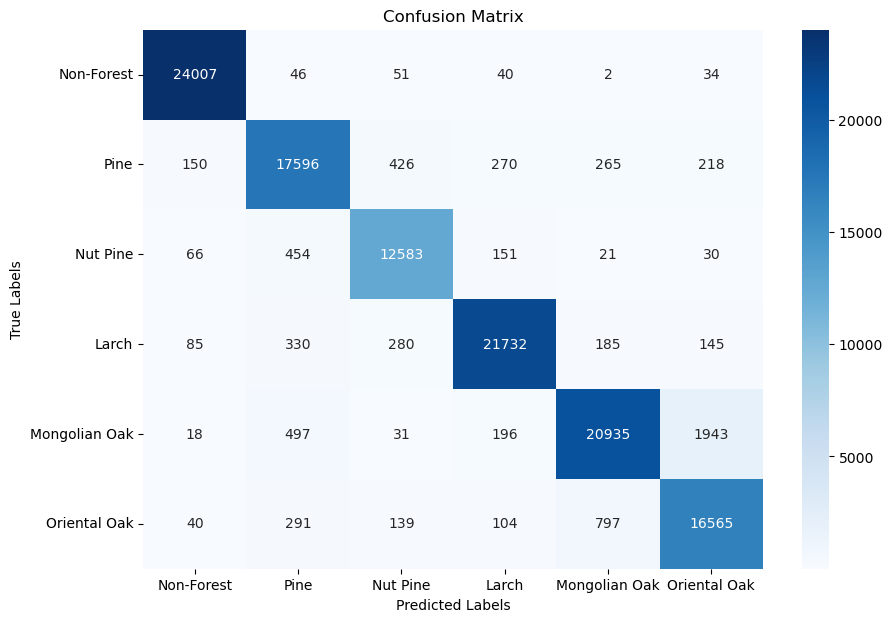

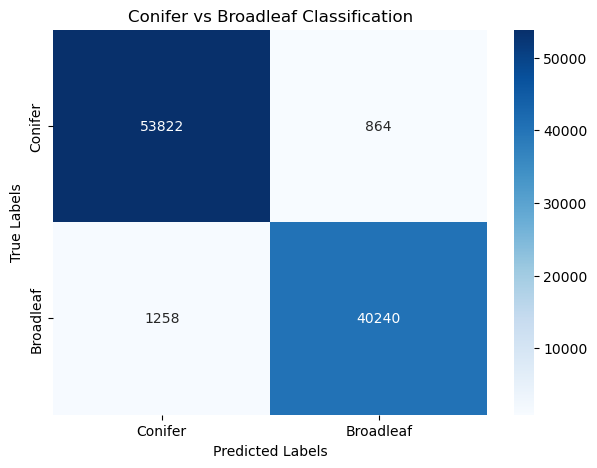

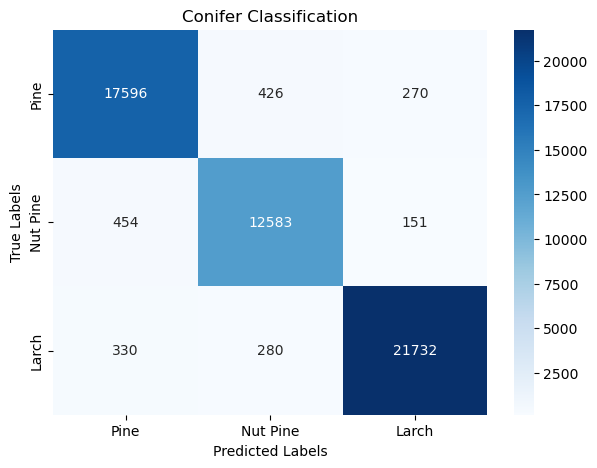

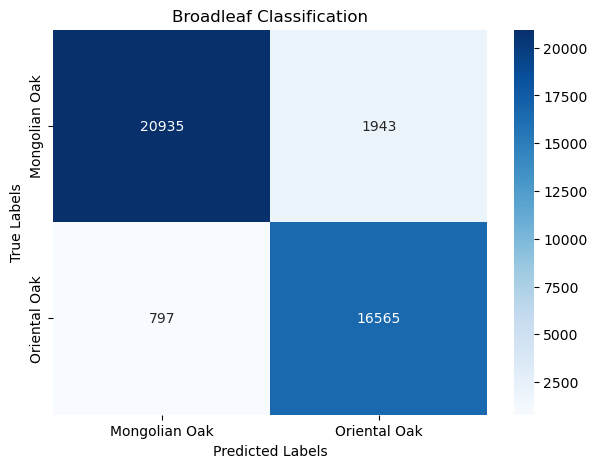

validation data


Evaluation Progress: 100%|██████████████████████████████████| 936/936 [00:07<00:00, 133.48it/s]


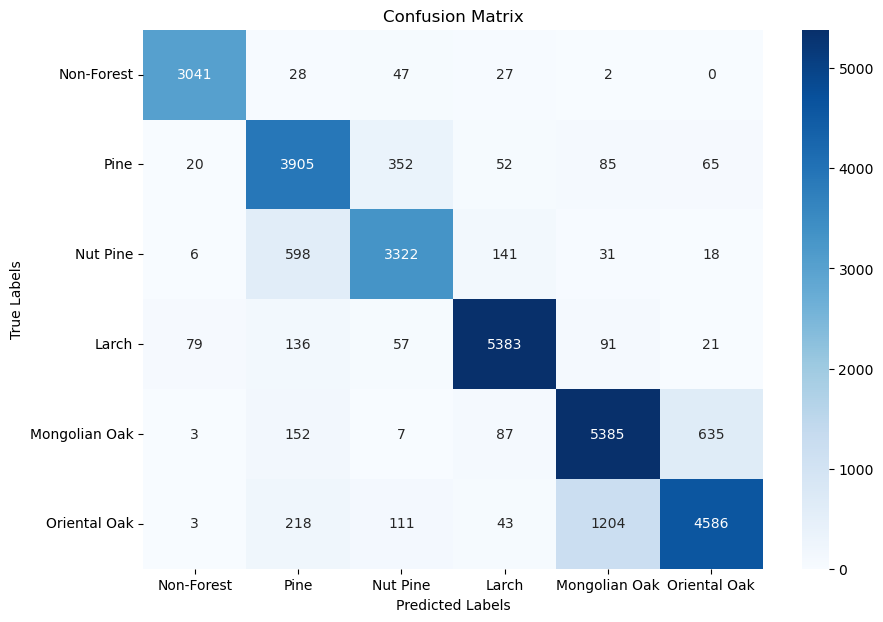

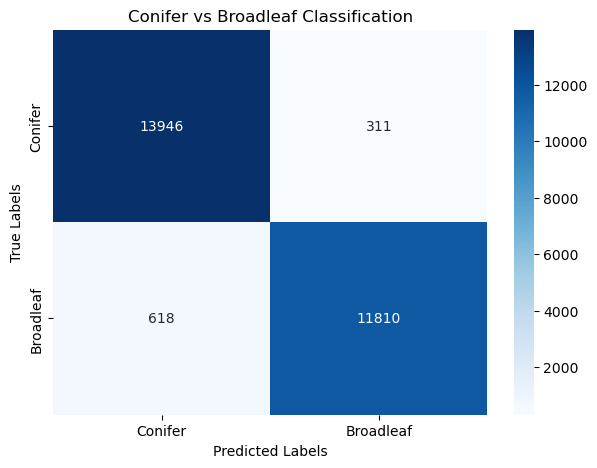

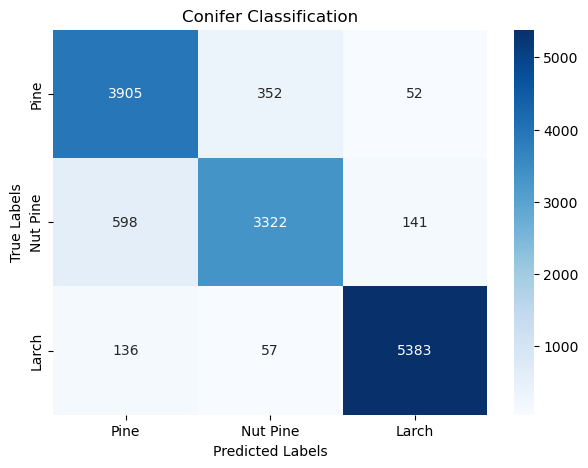

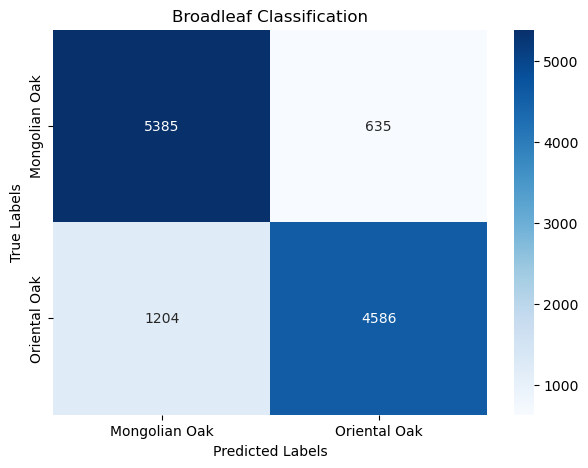

7


Epoch 1/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 129.80it/s]



Epoch [1/100], Train Loss: 0.9856, Train Accuracy: 63.54%, Val Loss: 0.7226, Val Accuracy: 74.40%



Epoch 2/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 126.77it/s]



Epoch [2/100], Train Loss: 0.6668, Train Accuracy: 76.74%, Val Loss: 0.6334, Val Accuracy: 76.62%



Epoch 3/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 128.65it/s]



Epoch [3/100], Train Loss: 0.5773, Train Accuracy: 79.60%, Val Loss: 0.5988, Val Accuracy: 76.50%



Epoch 4/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 128.31it/s]



Epoch [4/100], Train Loss: 0.5198, Train Accuracy: 81.45%, Val Loss: 0.5504, Val Accuracy: 78.86%



Epoch 5/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 129.61it/s]



Epoch [5/100], Train Loss: 0.4800, Train Accuracy: 83.06%, Val Loss: 0.5520, Val Accuracy: 79.83%



Epoch 6/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 132.09it/s]



Epoch [6/100], Train Loss: 0.4507, Train Accuracy: 84.04%, Val Loss: 0.4961, Val Accuracy: 81.88%



Epoch 7/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 131.14it/s]



Epoch [7/100], Train Loss: 0.4281, Train Accuracy: 84.84%, Val Loss: 0.4991, Val Accuracy: 82.03%



Epoch 8/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 129.93it/s]



Epoch [8/100], Train Loss: 0.4068, Train Accuracy: 85.77%, Val Loss: 0.4842, Val Accuracy: 82.02%



Epoch 9/100 - Validation: 100%|█████████████████████████████| 936/936 [00:07<00:00, 131.57it/s]



Epoch [9/100], Train Loss: 0.3912, Train Accuracy: 86.28%, Val Loss: 0.4600, Val Accuracy: 83.65%



Epoch 10/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 128.18it/s]



Epoch [10/100], Train Loss: 0.3781, Train Accuracy: 86.70%, Val Loss: 0.4776, Val Accuracy: 82.39%



Epoch 11/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 128.58it/s]



Epoch [11/100], Train Loss: 0.3645, Train Accuracy: 87.22%, Val Loss: 0.4804, Val Accuracy: 83.58%



Epoch 12/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 128.35it/s]



Epoch [12/100], Train Loss: 0.3534, Train Accuracy: 87.67%, Val Loss: 0.4651, Val Accuracy: 83.39%



Epoch 13/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 127.14it/s]



Epoch [13/100], Train Loss: 0.3439, Train Accuracy: 87.96%, Val Loss: 0.4746, Val Accuracy: 83.71%



Epoch 14/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 129.71it/s]



Epoch [14/100], Train Loss: 0.3350, Train Accuracy: 88.29%, Val Loss: 0.4577, Val Accuracy: 84.14%



Epoch 15/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 128.84it/s]



Epoch [15/100], Train Loss: 0.3272, Train Accuracy: 88.57%, Val Loss: 0.4492, Val Accuracy: 84.84%



Epoch 16/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 131.15it/s]



Epoch [16/100], Train Loss: 0.3184, Train Accuracy: 88.83%, Val Loss: 0.4737, Val Accuracy: 83.99%



Epoch 17/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 128.78it/s]



Epoch [17/100], Train Loss: 0.3123, Train Accuracy: 89.11%, Val Loss: 0.4619, Val Accuracy: 84.36%



Epoch 18/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 125.13it/s]



Epoch [18/100], Train Loss: 0.3039, Train Accuracy: 89.42%, Val Loss: 0.4816, Val Accuracy: 84.34%



Epoch 19/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 127.32it/s]



Epoch [19/100], Train Loss: 0.2999, Train Accuracy: 89.51%, Val Loss: 0.5190, Val Accuracy: 82.93%



Epoch 20/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 129.60it/s]



Epoch [20/100], Train Loss: 0.2928, Train Accuracy: 89.80%, Val Loss: 0.4738, Val Accuracy: 84.21%



Epoch 21/100 - Validation: 100%|████████████████████████████| 936/936 [00:07<00:00, 128.38it/s]



Epoch [21/100], Train Loss: 0.2878, Train Accuracy: 90.00%, Val Loss: 0.4364, Val Accuracy: 85.51%



Epoch 22/100 - Training:  88%|█████████████████████████▌   | 3330/3773 [00:55<00:07, 61.34it/s]

In [ ]:
bands = 4
num_epochs = 100
patch_sizes = [1, 3, 5, 7, 9, 11]
result_df_dicts = {"patch_size": [],
                   "data_type" : [],
                   "df" : []}
os.makedirs("./checkpoints/patch_size_test", exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/naive' #원천데이터 주소

class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands, patch_size):
        self.bands = bands
        self.patch_size = patch_size
    def __call__(self, x):
        return x.view(12, self.bands, self.patch_size, self.patch_size).permute(1, 0, 2, 3)

def get_transform(bands, patch_size, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands, patch_size)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x

for patch_size in patch_sizes:
    
    print(patch_size)
    transform = get_transform(bands, patch_size, scale_channels)
    
    train_dataset = TiffDataset(
                large_tif_dir = large_tif_dir,
                file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
                label_file = "../../data/label_data/species/label_mapping_sampled.csv",
                box_filter_fn = lambda box_number: not val_filter(box_number),
                patch_size = patch_size,
                transform=transform
            )

    val_dataset = TiffDataset(
                large_tif_dir = large_tif_dir,
                file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
                label_file ="../../data/label_data/species/label_mapping_sampled.csv",
                box_filter_fn = val_filter,
                patch_size = patch_size,
                transform=transform
            )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = TransformerModel(patch_size=patch_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100)
    torch.save(best_model_state, f"./checkpoints/patch_size_test/transformer_{bands}_{patch_size}_{num_epochs}.pth")
    model.load_state_dict(best_model_state)

    print("train data")
    train_df = evaluate_model_with_cm(model, train_loader, num_classes=6)
    result_df_dicts["patch_size"].append(patch_size)
    result_df_dicts["data_type"].append("train_data")
    result_df_dicts["df"].append(train_df)

    print("validation data")
    validation_df = evaluate_model_with_cm(model, val_loader, num_classes=6)
    result_df_dicts["patch_size"].append(patch_size)
    result_df_dicts["data_type"].append("validation")
    result_df_dicts["df"].append(validation_df)

    # ✅ 메모리 정리
    del model, train_loader, val_loader, optimizer, criterion
    torch.cuda.empty_cache()

In [ ]:
# 모든 데이터를 하나의 데이터프레임으로 합치기
final_df = pd.concat([
    df.assign(patch_size=patch, data_type=dt)
    for patch, dt, df in zip(result_df_dicts["patch_size"], result_df_dicts["data_type"], result_df_dicts["df"])
], ignore_index=False)

# 인덱스를 리셋하고 정리
final_df.reset_index(inplace=True)
final_df.rename(columns={"index": "class"}, inplace=True)

# 저장
os.makedirs("./results", exist_ok=True) 
final_df.to_csv("./results/patch_size_transformer_results.csv", index=False, encoding="utf-8-sig")

In [ ]:
# 데이터 로드
df = pd.read_csv("./results/patch_size_transformer_results.csv")

# macro avg이면서 validation 데이터만 필터링
filtered_df = df[(df['class'] == 'macro avg') & (df['data_type'] == 'validation')]

# 카테고리별 데이터 분할
categories = filtered_df['Category'].unique()

# 시각화
plt.figure(figsize=(12, 8))

for i, category in enumerate(categories, 1):
    plt.subplot(2, 2, i)
    
    # 특정 카테고리 데이터 선택
    cat_df = filtered_df[filtered_df['Category'] == category]
    
    # 그래프 그리기 (patch_size별 f1-score 그대로 사용)
    sns.lineplot(x=cat_df['patch_size'], y=cat_df['f1-score'], marker='o', label=category)
    
    plt.title(category)
    plt.xlabel('Patch Size')
    plt.ylabel('F1-Score')
    plt.xticks(sorted(cat_df['patch_size'].unique()))  # X축 정렬
    plt.grid(True)

plt.tight_layout()
plt.show()



# macro avg이면서 validation 데이터만 필터링
filtered_df = df[(df['class'] == 'accuracy') & (df['data_type'] == 'validation')]

# 카테고리별 데이터 분할
categories = filtered_df['Category'].unique()

# 시각화
plt.figure(figsize=(12, 8))

for i, category in enumerate(categories, 1):
    plt.subplot(2, 2, i)
    
    # 특정 카테고리 데이터 선택
    cat_df = filtered_df[filtered_df['Category'] == category]
    
    # 그래프 그리기 (patch_size별 f1-score 그대로 사용)
    sns.lineplot(x=cat_df['patch_size'], y=cat_df['f1-score'], marker='o', label=category)
    
    plt.title(category)
    plt.xlabel('Patch Size')
    plt.ylabel('Accuracy')
    plt.xticks(sorted(cat_df['patch_size'].unique()))  # X축 정렬
    plt.grid(True)

plt.tight_layout()
plt.show()